Notebook to select genes and species
====================================

Basic enums
-----------

In [1]:
from yspecies import *
from yspecies.enums import *

## Parameters cell ##
Parameters are overiddent by papermill when run inside DVC stages

In [2]:
# Parameters
drop_species = []#[ "Tupaia_belangeri", "Erinaceus_europaeus"] #["Tursiops_truncatus","Sarcophilus_harrisii","Cavia_aperea", "Tupaia_belangeri", "Erinaceus_europaeus"]
orthology =  Orthology.one2oneplus_directed.name
reference_species = "Homo_sapiens"
animal_class = AnimalClass.mammals.name
na_threshold = 0.2

reading parameters

In [3]:
ortho = Orthology[orthology]
cl = AnimalClass[animal_class]

#### Load dependencies ####

In [4]:
from dataclasses import dataclass
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
#settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import pprint
pp = pprint.PrettyPrinter(indent=4)

#### Load pathes ####

In [6]:
from pathlib import Path
if(Path("./data").exists()):
    base_dir = Path("./")
else:
    base_dir = Path("../")
print(base_dir.absolute())

data_dir = base_dir / "data"
input_dir = data_dir / "input"
interim_dir = data_dir / "interim"
output_dir =  data_dir / "output"
genes_dir = input_dir / "genes"
expressions_dir = input_dir / "expressions"
path_by_class = genes_dir / "by_animal_class"
path_all = genes_dir / "all"

/data/sources/species/notebooks/..


In [7]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt

## Load gene tables ##

In [8]:
load_path = path_by_class / cl.name.capitalize() / (ortho.name + ".tsv")
load_path

PosixPath('../data/input/genes/by_animal_class/Mammalia/one2oneplus_directed.tsv')

In [9]:
def load_table(path: Path, index: str = None, dtype: str = None):    
    if index is None:
        return pd.read_csv(str(path), sep="\t", dtype=dtype)
    else:
        return pd.read_csv(str(path), sep="\t", index_col=index, dtype=dtype)

genes = load_table(path_by_class / cl.name.capitalize() / (ortho.name + ".tsv"), reference_species, "str")
print(genes.shape)
genes.head()

(67996, 35)


,Pan_troglodytes,Equus_caballus,Pan_paniscus,Tursiops_truncatus,Macaca_mulatta,Macaca_fascicularis,Macaca_nemestrina,Ailuropoda_melanoleuca,Ursus_americanus,Heterocephalus_glaber,Rhinolophus_ferrumequinum,Felis_catus,Sus_scrofa,Bos_grunniens,Ovis_aries,Callithrix_jacchus,Ornithorhynchus_anatinus,Phascolarctos_cinereus,Capra_hircus,Suricata_suricatta,Bos_taurus,Otolemur_garnettii,Microcebus_murinus,Sarcophilus_harrisii,Cavia_porcellus,Erinaceus_europaeus,Tupaia_belangeri,Oryctolagus_cuniculus,Meriones_unguiculatus,Cavia_aperea,Monodelphis_domestica,Mus_musculus,Mesocricetus_auratus,Rattus_norvegicus,Mus_spicilegus
Homo_sapiens,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENSG00000242265,ENSPTRG00000023648,ENSECAG00000001603,ENSPPAG00000030053,ENSTTRG00000003114,ENSMMUG00000032524,ENSMFAG00000045560,ENSMNEG00000037924,ENSAMEG00000019304,NaN,NaN,ENSRFEG00010011916,ENSFCAG00000041002,ENSSSCG00000036049,ENSBGRG00000010269,ENSOARG00000002475,ENSCJAG00000033086,NaN,ENSPCIG00000028966,NaN,ENSSSUG00005000112,ENSBTAG00000053735,ENSOGAG00000031169,ENSMICG00000001469,NaN,NaN,NaN,NaN,ENSOCUG00000027535,ENSMUGG00000022866;ENSMUGG00000022860,ENSCAPG00000010493,NaN,ENSMUSG00000092035,ENSMAUG00000018656,NaN,ENSMSIG00000000323
ENSG00000139990,ENSPTRG00000006478,ENSECAG00000010524,ENSPPAG00000042013,ENSTTRG00000013941,ENSMMUG00000019346,ENSMFAG00000003413,ENSMNEG00000028207,ENSAMEG00000014443,ENSUAMG00000010770,ENSHGLG00100003336;ENSHGLG00100017958;ENSHGLG0...,ENSRFEG00010004811,ENSFCAG00000029516,ENSSSCG00000039701,ENSBGRG00000007044,ENSOARG00000021180,ENSCJAG00000042954,ENSOANG00000012620,ENSPCIG00000010372,ENSCHIG00000021848,ENSSSUG00005006529,ENSBTAG00000048519,ENSOGAG00000008452,ENSMICG00000046667,ENSSHAG00000000665,ENSCPOG00000032392,ENSEEUG00000011616,NaN,ENSOCUG00000010281,ENSMUGG00000023917,ENSCAPG00000014053,ENSMODG00000010219,ENSMUSG00000049106,ENSMAUG00000004350,ENSRNOG00000004556,ENSMSIG00000015740
ENSG00000073921,ENSPTRG00000004141,ENSECAG00000019264,ENSPPAG00000036162,ENSTTRG00000001554,ENSMMUG00000019618,ENSMFAG00000002978,ENSMNEG00000029285,ENSAMEG00000008778,ENSUAMG00000018059,ENSHGLG00100018440,ENSRFEG00010012989,ENSFCAG00000029123,ENSSSCG00000014913,ENSBGRG00000024679,ENSOARG00000004654,ENSCJAG00000014262,ENSOANG00000013205,ENSPCIG00000018862,ENSCHIG00000015634,ENSSSUG00005014072,ENSBTAG00000001657,ENSOGAG00000013950,ENSMICG00000017261,ENSSHAG00000004629,ENSCPOG00000020758,ENSEEUG00000013932,ENSTBEG00000000600,ENSOCUG00000023809,ENSMUGG00000002616,ENSCAPG00000000355,ENSMODG00000004297,ENSMUSG00000039361,ENSMAUG00000011448,ENSRNOG00000018322,ENSMSIG00000002381
ENSG00000139687,ENSPTRG00000005864,ENSECAG00000014575,ENSPPAG00000002165,ENSTTRG00000004232,ENSMMUG00000007891,ENSMFAG00000004544,ENSMNEG00000030265,ENSAMEG00000003640,ENSUAMG00000011956,ENSHGLG00100008595,ENSRFEG00010000766,ENSFCAG00000024529,ENSSSCG00000009401,ENSBGRG00000020100,ENSOARG00000008246,ENSCJAG00000009076,ENSOANG00000031580;ENSOANG00000015555,ENSPCIG00000029307,ENSCHIG00000004374,ENSSSUG00005003247,ENSBTAG00000006640,ENSOGAG00000007461,ENSMICG00000001747,ENSSHAG00000014024,ENSCPOG00000008683,ENSEEUG00000000076,ENSTBEG00000014454,ENSOCUG00000016404,ENSMUGG00000019124,ENSCAPG00000014795,ENSMODG00000011168,ENSMUSG00000022105,ENSMAUG00000020865,ENSRNOG00000016029,ENSMSIG00000007265
ENSG00000119977,ENSPTRG00000002786,ENSECAG00000016594,ENSPPAG00000043730,ENSTTRG00000003261,ENSMMUG00000003103,ENSMFAG00000001575,ENSMNEG00000037026,ENSAMEG00000015948,ENSUAMG00000021674,ENSHGLG00100006578,ENSRFEG00010015913,ENSFCAG00000023675,ENSSSCG00000010496,ENSBGRG00000025629,ENSOARG00000006497,ENSCJAG00000016206,ENSOANG00000019944,ENSPCIG00000020525,ENSCHIG00000021683,ENSSSUG00005007325,ENSBTAG00000011841,ENSOGAG00000003757,ENSMICG00000015970,NaN,ENSCPOG00000021974,ENSEEUG00000002616,ENSTBEG00000010577,ENSOCUG00000005964,ENSMUGG00000008987,NaN,ENSMODG00000004976,ENSMUSG00000025008,ENSMAUG00000021808,ENSRNOG00000047112;ENSRNOG00000060994,ENSMSIG00000005758


### Load species and samples ###

In [10]:
species = load_table(input_dir / "species.tsv")
species_in_class = species[species.animal_class.eq(cl.name)]
print("Selected "+ cl.name + " class with " + str(species_in_class.shape[0]) + " species" )
species_in_class.head(3)

Selected Mammalia class with 72 species


,species,common_name,animal_class,lifespan,ensembl_url,mass_g,metabolic_rate,temperature,temperature_kelvin,gestation_days,taxon,female_maturity_days,male_maturity_days,litters_per_year,inter_birth_interval,birth_weight_g,weaning_weight_g
26,Homo_sapiens,Human,Mammalia,122.5,https://www.ensembl.org/Homo_sapiens,70000.0,82.78,37.0,310.15,280.0,taxon#9606,1.0,5110.0,0.3,639.0,3312.5,NaN
27,Loxodonta_africana,African bush elephant,Mammalia,65.0,https://www.ensembl.org/Loxodonta_africana,NaN,NaN,36.2,309.35,670.0,taxon#9785,1.0,3650.0,0.2,1707.0,105000.0,NaN
28,Gorilla_gorilla,Gorilla,Mammalia,60.1,https://www.ensembl.org/Gorilla_gorilla,NaN,NaN,35.5,308.65,256.0,taxon#9595,1.0,4015.0,0.3,1397.0,2061.4,NaN


In [11]:
selected_species = species_in_class[~species_in_class.species.isin(drop_species)]
"after deleting some species"
selected_species.shape

(72, 17)

In [12]:
samples = load_table(input_dir / "samples.tsv")
samples_ext = samples.merge(species, on="species", how="inner")
selected_samples_ext = samples_ext[samples_ext["animal_class"] ==  cl.name]
selected_samples_ext.head(3)

,bioproject,series,run,species,tissue,sample_name,characteristics,sequencer,age,sex,tumor,source,study,study_title,salmon_version,library_layout,library_selection,library_strategy,lib_type,bootstrap,modified,protocol,common_name,animal_class,lifespan,ensembl_url,mass_g,metabolic_rate,temperature,temperature_kelvin,gestation_days,taxon,female_maturity_days,male_maturity_days,litters_per_year,inter_birth_interval,birth_weight_g,weaning_weight_g
0,PRJNA247712,PRJNA247712,SRR1287653,Ailuropoda_melanoleuca,Blood,SL01,no;Model organism or animal;19;female;blood;SL...,Illumina_HiSeq_2000,19,female,no,blood,https://trace.ncbi.nlm.nih.gov/Traces/sra/?stu...,The giant panda blood Transcriptome,1.1.0,PAIRED,PCR,RNA-Seq,A,96,13:39.812,NaN,Giant panda,Mammalia,36.8,https://www.ensembl.org/Ailuropoda_melanoleuca,NaN,NaN,NaN,NaN,48.0,taxon#9646,1.5,2192.0,0.7,548.0,110.0,NaN
1,PRJNA247712,PRJNA247712,SRR1287654,Ailuropoda_melanoleuca,Blood,XB01,no;Model organism or animal;12;male;blood;XB01...,Illumina_HiSeq_2000,12,male,no,blood,https://trace.ncbi.nlm.nih.gov/Traces/sra/?stu...,The giant panda blood Transcriptome,1.1.0,PAIRED,PCR,RNA-Seq,A,96,40:17.122,NaN,Giant panda,Mammalia,36.8,https://www.ensembl.org/Ailuropoda_melanoleuca,NaN,NaN,NaN,NaN,48.0,taxon#9646,1.5,2192.0,0.7,548.0,110.0,NaN
2,PRJNA247712,PRJNA247712,SRR1287655,Ailuropoda_melanoleuca,Blood,XB02,no;Model organism or animal;6;female;blood;XB0...,Illumina_HiSeq_2000,6,female,no,blood,https://trace.ncbi.nlm.nih.gov/Traces/sra/?stu...,The giant panda blood Transcriptome,1.1.0,PAIRED,PCR,RNA-Seq,A,128,23:40.197,NaN,Giant panda,Mammalia,36.8,https://www.ensembl.org/Ailuropoda_melanoleuca,NaN,NaN,NaN,NaN,48.0,taxon#9646,1.5,2192.0,0.7,548.0,110.0,NaN


Check issues with species annotations
-------------------------------------

In [13]:
samples_anti = samples.merge(species_in_class, on="species", how='outer', indicator=True)
samples_species = samples_anti[['_merge','run', 'species', 'tissue', 'sample_name',
       'characteristics', 'sequencer', 'age', 'sex',"species"]].sort_values(by="_merge")
need_annotation = samples_species[samples_species["_merge"]=="left_only"]
print(need_annotation.shape)
need_annotation

(89, 10)


,_merge,run,species,tissue,sample_name,characteristics,sequencer,age,sex,species
220,left_only,SRR1533656,Esox_lucius,Liver,H_El_6,no;unknown;Model organism or animal;unknown;fe...,Illumina_HiSeq_2000,unknown,female,Esox_lucius
64,left_only,SRR514109,Callorhinchus_milii,Brain,eshark-brain,no;Australia: Tasmania;none;Model organism or ...,Illumina_Genome_Analyzer_IIx,unknown,unknown,Callorhinchus_milii
63,left_only,SRR514107,Callorhinchus_milii,Heart,eshark-heart,no;Australia: Tasmania;none;Model organism or ...,Illumina_Genome_Analyzer_IIx,unknown,unknown,Callorhinchus_milii
62,left_only,SRR514105,Callorhinchus_milii,Kidney,eshark-kidney,no;Australia: Tasmania;none;Model organism or ...,Illumina_Genome_Analyzer_IIx,unknown,unknown,Callorhinchus_milii
61,left_only,SRR513760,Callorhinchus_milii,Liver,eshark-liver,no;Australia: Tasmania;none;Model organism or ...,Illumina_Genome_Analyzer_II,unknown,unknown,Callorhinchus_milii
196,left_only,SRR1299086,Electrophorus_electricus,Kidney,Eelectricus_RNA_kidney,no;not applicable;no treatment;Model organism ...,Illumina_HiSeq_2000,undetermined,not determined,Electrophorus_electricus
647,left_only,SRR629641,Pogona_vitticeps,Liver,Bearded Dragon,Adult;liver;no,Illumina_HiSeq_2000,Adult,NaN,Pogona_vitticeps
641,left_only,SRR3955461,Parus_major,Liver,Rural6_liver,no;Sweden: Vomb;Model organism or animal;3K+;m...,Illumina_HiSeq_2000,3K+,male,Parus_major
640,left_only,SRR3955460,Parus_major,Liver,Rural5_liver,no;Sweden: Vomb;Model organism or animal;3K+;m...,Illumina_HiSeq_2000,3K+,male,Parus_major
195,left_only,SRR1299081,Electrophorus_electricus,Heart,Eelectricus_RNA_heart,no;not applicable;no treatment;Model organism ...,Illumina_HiSeq_2000,undetermined,not determined,Electrophorus_electricus


Count how many samples do we have by tissue and species

In [14]:
by_tissue_count = selected_samples_ext.groupby("tissue").run.count().sort_values(ascending=False)
by_tissue_count

tissue
Brain     220
Liver     201
Kidney    115
Heart      66
Lung       38
Blood      31
Skin       23
Muscle      8
Testis      2
Testes      2
Ileum       2
Fat         2
Mix         1
Name: run, dtype: int64

In [15]:
by_species_count = selected_samples_ext.groupby(["species", "common_name"]).run.count().sort_values(ascending=False).to_frame().reset_index()
by_species_count

,species,common_name,run
0,Canis_lupus_familiaris,Dog,68
1,Gorilla_gorilla,Gorilla,63
2,Rattus_norvegicus,Norway rat,57
3,Mus_musculus,House mouse,39
4,Meriones_unguiculatus,Mongolian jird,32
5,Homo_sapiens,Human,29
6,Cavia_porcellus,Guinea pig,26
7,Tursiops_truncatus,Bottlenosed dolphin,26
8,Mesocricetus_auratus,Golden hamster,24
9,Bos_grunniens,Yak,22


In [16]:
def samples_in(*cols):
    spc = by_species_count.set_index("species")
    return sum([spc.loc[c].run for c in cols])


In [17]:
by_species_tissue_count = selected_samples_ext.sort_values(["species", "tissue"], ascending=False).groupby(["species", "common_name", "tissue"]).run.count()
by_species_tissue_count

species                     common_name                     tissue
Ailuropoda_melanoleuca      Giant panda                     Blood      3
                                                            Liver      1
Bos_grunniens               Yak                             Brain      1
                                                            Heart      5
                                                            Kidney     5
                                                            Liver      5
                                                            Lung       6
Bos_taurus                  Domestic cattle                 Blood      1
                                                            Brain      4
                                                            Kidney     4
                                                            Liver      6
                                                            Muscle     1
Callithrix_jacchus          White-tufted-ear marmoset    

### Filter genes ###

count intersection genes

In [18]:
def gc(df: pd.DataFrame, species: pd.DataFrame = None, index_field: str = None) -> pd.DataFrame:
    frame = df.notna().sum().sort_values(ascending=False).to_frame("genes")
    result = frame.reset_index().rename( columns= {"index": "species"})
    if species is None:
        return result
    else:
        field = "common_name" if index_field is None else index_field        
        return result.merge(species, on="species", how="inner").set_index(field)

def count_genes(df: pd.DataFrame, *without):
    return df.drop(columns=np.array(without)).dropna().shape


### Genes with deleted species and too many NA ###

In [19]:
 genes.drop(columns =drop_species).dropna(thresh=0.001).shape

(21725, 35)

Computing the number of not_na_values

In [20]:
not_na_number = (1-na_threshold) * genes.shape[1]
not_na_number

28.0

In [21]:
selected_genes = genes.drop(columns =drop_species).dropna(thresh=not_na_number)
print("before = "+str(genes.dropna(thresh=1).shape))
print("after = "+str(selected_genes.shape))
selected_genes.head()

before = (21725, 35)
after = (14364, 35)


,Pan_troglodytes,Equus_caballus,Pan_paniscus,Tursiops_truncatus,Macaca_mulatta,Macaca_fascicularis,Macaca_nemestrina,Ailuropoda_melanoleuca,Ursus_americanus,Heterocephalus_glaber,Rhinolophus_ferrumequinum,Felis_catus,Sus_scrofa,Bos_grunniens,Ovis_aries,Callithrix_jacchus,Ornithorhynchus_anatinus,Phascolarctos_cinereus,Capra_hircus,Suricata_suricatta,Bos_taurus,Otolemur_garnettii,Microcebus_murinus,Sarcophilus_harrisii,Cavia_porcellus,Erinaceus_europaeus,Tupaia_belangeri,Oryctolagus_cuniculus,Meriones_unguiculatus,Cavia_aperea,Monodelphis_domestica,Mus_musculus,Mesocricetus_auratus,Rattus_norvegicus,Mus_spicilegus
Homo_sapiens,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENSG00000139990,ENSPTRG00000006478,ENSECAG00000010524,ENSPPAG00000042013,ENSTTRG00000013941,ENSMMUG00000019346,ENSMFAG00000003413,ENSMNEG00000028207,ENSAMEG00000014443,ENSUAMG00000010770,ENSHGLG00100003336;ENSHGLG00100017958;ENSHGLG0...,ENSRFEG00010004811,ENSFCAG00000029516,ENSSSCG00000039701,ENSBGRG00000007044,ENSOARG00000021180,ENSCJAG00000042954,ENSOANG00000012620,ENSPCIG00000010372,ENSCHIG00000021848,ENSSSUG00005006529,ENSBTAG00000048519,ENSOGAG00000008452,ENSMICG00000046667,ENSSHAG00000000665,ENSCPOG00000032392,ENSEEUG00000011616,NaN,ENSOCUG00000010281,ENSMUGG00000023917,ENSCAPG00000014053,ENSMODG00000010219,ENSMUSG00000049106,ENSMAUG00000004350,ENSRNOG00000004556,ENSMSIG00000015740
ENSG00000073921,ENSPTRG00000004141,ENSECAG00000019264,ENSPPAG00000036162,ENSTTRG00000001554,ENSMMUG00000019618,ENSMFAG00000002978,ENSMNEG00000029285,ENSAMEG00000008778,ENSUAMG00000018059,ENSHGLG00100018440,ENSRFEG00010012989,ENSFCAG00000029123,ENSSSCG00000014913,ENSBGRG00000024679,ENSOARG00000004654,ENSCJAG00000014262,ENSOANG00000013205,ENSPCIG00000018862,ENSCHIG00000015634,ENSSSUG00005014072,ENSBTAG00000001657,ENSOGAG00000013950,ENSMICG00000017261,ENSSHAG00000004629,ENSCPOG00000020758,ENSEEUG00000013932,ENSTBEG00000000600,ENSOCUG00000023809,ENSMUGG00000002616,ENSCAPG00000000355,ENSMODG00000004297,ENSMUSG00000039361,ENSMAUG00000011448,ENSRNOG00000018322,ENSMSIG00000002381
ENSG00000139687,ENSPTRG00000005864,ENSECAG00000014575,ENSPPAG00000002165,ENSTTRG00000004232,ENSMMUG00000007891,ENSMFAG00000004544,ENSMNEG00000030265,ENSAMEG00000003640,ENSUAMG00000011956,ENSHGLG00100008595,ENSRFEG00010000766,ENSFCAG00000024529,ENSSSCG00000009401,ENSBGRG00000020100,ENSOARG00000008246,ENSCJAG00000009076,ENSOANG00000031580;ENSOANG00000015555,ENSPCIG00000029307,ENSCHIG00000004374,ENSSSUG00005003247,ENSBTAG00000006640,ENSOGAG00000007461,ENSMICG00000001747,ENSSHAG00000014024,ENSCPOG00000008683,ENSEEUG00000000076,ENSTBEG00000014454,ENSOCUG00000016404,ENSMUGG00000019124,ENSCAPG00000014795,ENSMODG00000011168,ENSMUSG00000022105,ENSMAUG00000020865,ENSRNOG00000016029,ENSMSIG00000007265
ENSG00000119977,ENSPTRG00000002786,ENSECAG00000016594,ENSPPAG00000043730,ENSTTRG00000003261,ENSMMUG00000003103,ENSMFAG00000001575,ENSMNEG00000037026,ENSAMEG00000015948,ENSUAMG00000021674,ENSHGLG00100006578,ENSRFEG00010015913,ENSFCAG00000023675,ENSSSCG00000010496,ENSBGRG00000025629,ENSOARG00000006497,ENSCJAG00000016206,ENSOANG00000019944,ENSPCIG00000020525,ENSCHIG00000021683,ENSSSUG00005007325,ENSBTAG00000011841,ENSOGAG00000003757,ENSMICG00000015970,NaN,ENSCPOG00000021974,ENSEEUG00000002616,ENSTBEG00000010577,ENSOCUG00000005964,ENSMUGG00000008987,NaN,ENSMODG00000004976,ENSMUSG00000025008,ENSMAUG00000021808,ENSRNOG00000047112;ENSRNOG00000060994,ENSMSIG00000005758
ENSG00000242866,ENSPTRG00000006998;ENSPTRG00000048910,ENSECAG00000009715,ENSPPAG00000038965,ENSTTRG00000005846,ENSMMUG00000021840,ENSMFAG00000045628,ENSMNEG00000011427,ENSAMEG00000015280,ENSUAMG00000014982,ENSHGLG00100003594,ENSRFEG00010004480,ENSFCAG00000006605,ENSSSCG00000004702,ENSBGRG00000011966,ENSOARG00000010634,ENSCJAG00000002654,ENSOANG00000030307,ENSPCIG00000018293,ENSCHIG00000022061,ENSSSUG00005021029,ENSBTAG00000007503,ENSOGAG00000006099,ENSMICG00000010153,ENSSHAG00000014160,ENSCPOG00000014222,ENSEEUG00000001664,NaN,ENSOCUG00000003112,ENSMUGG00000019615,ENSCAPG00000

## Missing value analysis ##

In [22]:
def show_missing(df: pd.DataFrame, title: str = "missing plot", ax = None):
     return sns.heatmap(df.notnull(), cbar=False,ax=ax).set_title(title)      
  
def compare_missing(one: pd.DataFrame, two: pd.DataFrame, one_title: str, two_title: str):
    print("Missing values comparison:")
    print("before: "+str(one.shape) +" || after: "+str(two.shape))    
    print("samples lost:"+str(samples_in(drop_species)))    
    print("Figures:")
    fig, axs = plt.subplots(1,2,figsize=(20,12))
    plt.subplots_adjust(left=0.125, bottom=0.3, right=0.9, top=1.1, wspace=0.3, hspace=0.8)        
    sns.heatmap(one.notnull(), cbar=False,ax=axs[0]).set_title(one_title)    
    sns.heatmap(two.notnull(), cbar=False,ax=axs[1]).set_title(two_title)


Missing values comparison:
before: (21725, 35) || after: (14364, 35)
samples lost:Series([], Name: run, dtype: int64)
Figures:


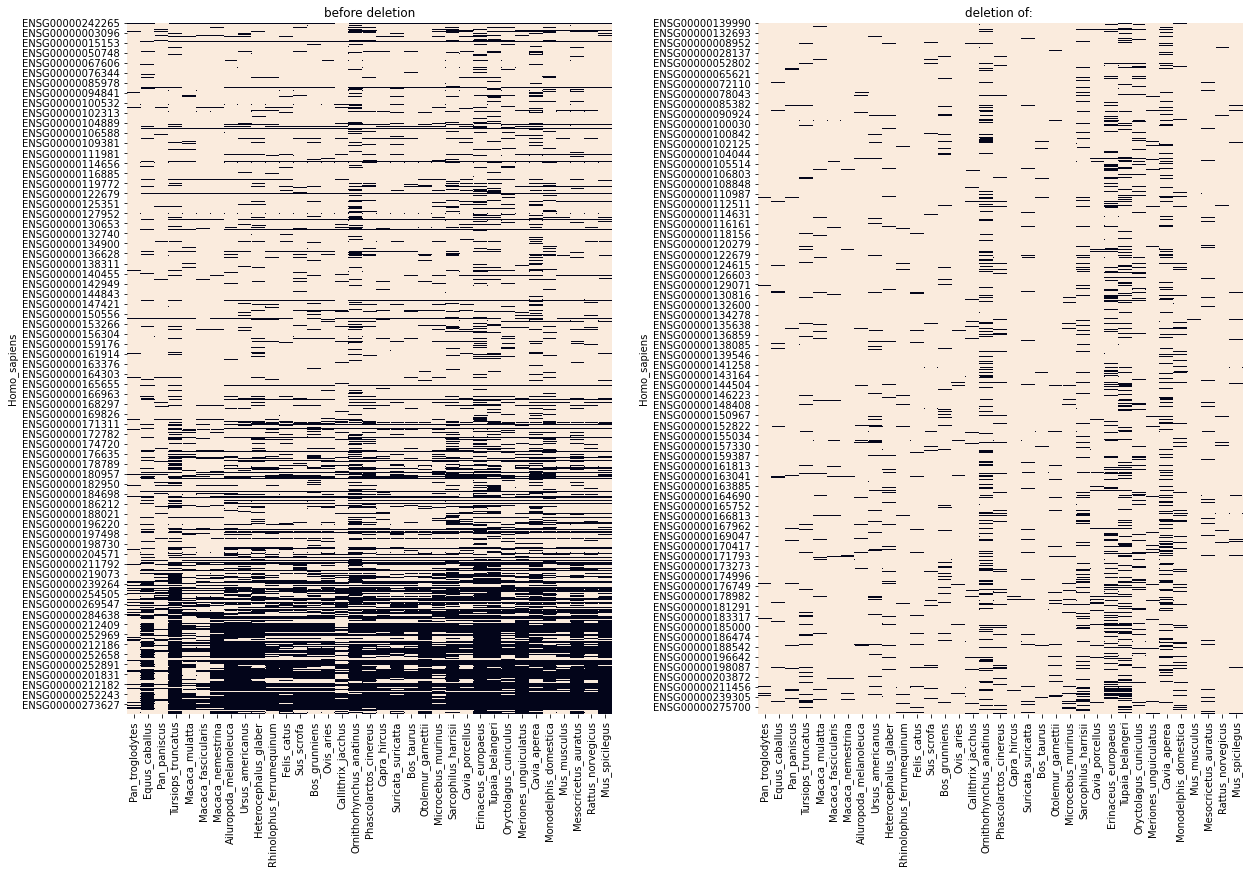

In [28]:
#compare_missing(genes.dropna(thresh=1), selected_genes, "before deletion", "deletion of: "+" ".join(drop_species))

## Writing removal results ##

Write selected species

In [24]:
selected_species_path = interim_dir / "selected_species.tsv" 
selected_species.to_csv(selected_species_path, sep = "\t", index = False)
print("wrote selected species to "+str(selected_species_path))

wrote selected species to ../data/interim/selected_species.tsv


In [26]:
selected_genes_path = interim_dir / "selected_genes.tsv" 
selected_genes.to_csv(selected_genes_path, sep = "\t", index = False)
print("wrote selected genes to "+str(selected_genes_path))

wrote selected genes to ../data/interim/selected_genes.tsv


In [27]:
selected_samples_path = interim_dir / "selected_samples.tsv" 
selected_samples_ext_upd = selected_samples_ext[~selected_samples_ext.species.isin(drop_species)]
print("selected samples: "+str(selected_samples_ext_upd.shape[0])+" out of "+ str(selected_samples_ext.shape[0])+ " in "+cl.name + " or "+str(samples_ext.shape[0])+" in total")
selected_samples_ext_upd.to_csv(str(selected_samples_path), sep="\t", index = False)
print("wrote selected samples to "+str(selected_samples_path))

selected samples: 711 out of 711 in Mammalia or 794 in total
wrote selected samples to ../data/interim/selected_samples.tsv
